# Domain Randomization of Deep Reinforcement Learning Environments for Zero-Shot Traffic Signal Control

In [1]:
from collections import defaultdict, namedtuple
import itertools
import os
import scipy
import shutil
import sys
from typing import List, Tuple
from tqdm import tqdm
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Colormap
import numpy as np
import pandas as pd
import sumolib

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)
from src.params import * 

agent_colors = {
    "TransferLight-DQN-random": "blue",
    "TransferLight-DQN-fixed": "lightskyblue",
    "TransferLight-A2C-random": "red",
    "TransferLight-A2C-fixed": "salmon",
    "FixedTime": "lightgray",
    "MaxPressure": "dimgray",
    "PressLight": "green"
}

In [2]:
vehicle_stats = []
intersection_stats = []
agent_stats = []

include_agents = ["FixedTime", "MaxPressure", "PressLight", "TransferLight-A2C-fixed", "TransferLight-A2C-random", "TransferLight-DQN-fixed", "TransferLight-DQN-random"]

jobs = []
print("Load files")
for agent, agents_spec in agent_specs.items():
    if agent not in include_agents:
        continue
    test_dir = os.path.join(agents_spec.agent_dir, "test")
    if not os.path.exists(test_dir):
        continue
    for checkpoint in os.listdir(test_dir):
        checkpoint_dir = os.path.join(test_dir, checkpoint)
        if not os.path.isdir(checkpoint_dir):
            continue
        for scenario in os.listdir(checkpoint_dir):
            scenario_dir = os.path.join(checkpoint_dir, scenario)
            if not os.path.isdir(scenario_dir):
                continue
            for stats_file in os.listdir(scenario_dir):
                stats_file_path = os.path.join(scenario_dir, stats_file)
                if stats_file.endswith("agent.csv") or stats_file.endswith("vehicle.csv") or stats_file.endswith(
                        "intersection.csv"):
                    jobs.append((agent, checkpoint, stats_file_path))
for agent, checkpoint, stats_file_path in tqdm(jobs):
    stats = pd.read_csv(stats_file_path)
    stats["agent"] = agent
    stats["checkpoint"] = checkpoint
    if stats_file_path.endswith("agent.csv"):
        stats = stats[
            ["agent", "checkpoint", "scenario", "intersection", "action_seq", "mc_means_seq", "mc_stds_seq"]]
        agent_stats.append(stats)
    elif stats_file_path.endswith("vehicle.csv"):
        stats = stats[["agent", "checkpoint", "scenario", "vehicle", "departure_time", "arrival_time",
                       "distance_seq", "lane_seq"]]
        vehicle_stats.append(stats)
    else:
        stats = stats[["agent", "checkpoint", "scenario", "intersection", "states", "queue_length_seq", "pressure_seq",
                       "normalized_pressure_seq", "waiting_time_seq"]]
        intersection_stats.append(stats)

dtypes = {"agent": str, "scenario": str, "checkpoint": str}
renaming = {"scenario": "specific_scenario"}
def extract_scenario(df: pd.DataFrame):
    specific_scenarios = df["specific_scenario"]
    return specific_scenarios.apply(lambda x: x.split("/")[0])

print("Combine agent stats")
agent_stats = (
    pd.concat(agent_stats, ignore_index=True, copy=False)
    .rename(columns=renaming)
    .assign(scenario=extract_scenario)
    .astype(dtypes)
)
print("Combine vehicle stats")
vehicle_stats = (
    pd.concat(vehicle_stats, ignore_index=True, copy=False)
    .rename(columns=renaming)
    .assign(scenario=extract_scenario)
    .assign(arrived=lambda x: x["arrival_time"] != -1)
    .assign(travel_time=lambda x: np.where(x["arrived"], x["arrival_time"] - x["departure_time"], np.nan))
    .astype(dtypes | {"vehicle": str})
)
print("Combine intersection stats")
intersection_stats = (
    pd.concat(intersection_stats, ignore_index=True, copy=False)
    .rename(columns=renaming)
    .assign(scenario=extract_scenario)
    .astype(dtypes)
)

Load files


100%|██████████████████████████████████████| 3189/3189 [00:25<00:00, 124.28it/s]


Combine agent stats
Combine vehicle stats
Combine intersection stats


In [13]:
scenario_duration = {
    "random": 900,
    "random_network": 900,
    "random_traffic": 900,
    "fixed": 900,
    "random-heavy": 3_600,
    "random-light": 3_600,
    "arterial": 3_600,
    "cologne3": 3_600,
    "cologne8": 3_600,
    "ingolstadt7": 3_600
}

def windowed_throughput(group: pd.DataFrame, window_len: int = 60) -> pd.DataFrame:
    scenario = group["scenario"].unique()[0]
    duration = scenario_duration[scenario] + 10
    eye = np.eye(duration, duration)
    binned_arrivals = pd.Series(np.sum(eye[group.query('arrival_time != -1')["arrival_time"]], axis=0))
    throughput = binned_arrivals.rolling(window_len, min_periods=1).sum()
    time = np.arange(0, duration)
    df = pd.DataFrame({"time": time, "value": throughput})
    return df.query(f'time < {duration - 10}')


throughput_df = (
    vehicle_stats
    .groupby(["agent", "checkpoint", "specific_scenario", "scenario"])
    .apply(windowed_throughput)
    .reset_index(level=-1, drop=True)
    .reset_index()
)

agg_throughput_df = (
    throughput_df
    .groupby(["agent", "checkpoint", "scenario"])
    .apply(lambda group: group["value"].agg(["mean", "std", "count"]))
    .reset_index()
)

In [4]:
travel_time_df = vehicle_stats[["agent", "checkpoint", "specific_scenario", "scenario", "vehicle", "travel_time"]]
agg_travel_time_df = (
    travel_time_df
    .groupby(["agent", "checkpoint", "scenario"])
    .apply(lambda group: group["travel_time"].agg(["mean", "std", "count"]))
    .reset_index()
)

## Learning Curves

In [67]:
def plot_training_curve(metric_stats: Dict[str, pd.DataFrame], scenarios: List[str], agents: List[str], agent_colors: Dict[str, str] = agent_colors, legend: bool = True, x_label: bool = True): 
    baselines = ["FixedTime", "MaxPressure"]
    ax_baseline_stats, ax_transferlight_stats, ax_metric, ax_scenario = {}, {}, {}, {}
    for row, (metric, stats) in enumerate(metric_stats.items()):
        for col, scenario in enumerate(scenarios):
            ax_baseline_stats[(row, col)] = (
                stats
                .query('checkpoint == "best"')
                .query('agent in @baselines')
                .query(f'scenario == "{scenario}"')
            )
            ax_transferlight_stats[(row, col)] = (
                stats
                .query('checkpoint != "best"')
                .query('agent in @agents')
                .query(f'scenario == "{scenario}"')
                .astype({"checkpoint": int})
                .rename({"checkpoint": "train_step"}, axis=1)
                .assign(train_step=lambda x: x["train_step"]-100)
                .sort_values("train_step")
            )
            ax_metric[(row, col)] = metric
            ax_scenario[(row, col)] = scenario
    baseline_linestyle = {"FixedTime": "dotted", "MaxPressure": "dashed"}
    
    n_cols = len(scenarios)
    n_rows = len(metric_stats)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 2.5 * n_rows))
    for row in range(n_rows):
        for col in range(n_cols):
            ax = axs[row, col] if n_rows > 1 else axs[col]
            metric = ax_metric[(row, col)]
            scenario = ax_scenario[(row, col)]
            baseline_stats = ax_baseline_stats[(row, col)]
            transferlight_stats = ax_transferlight_stats[(row, col)]
            for baseline in baselines:
                bl_stats = baseline_stats.query(f'agent == "{baseline}"')
                y = bl_stats["mean"].iat[0]
                ax.axhline(y, label=baseline, linestyle=baseline_linestyle[baseline], color=agent_colors[baseline])
            for agent in agents:
                tl_stats = transferlight_stats.query(f'agent == "{agent}"')
                x = tl_stats["train_step"]
                y = tl_stats["mean"]
                ax.plot(x, y, label=agent, color=agent_colors[agent], alpha=0.75)
            if row == 0:
                ax.set_title(f"Scenario: {scenario}")
            if col == 0:
                ax.set_ylabel(metric, fontsize=11)
                ax.yaxis.set_label_coords(-0.125, 0.5)
            handles, labels = ax.get_legend_handles_labels()
    if legend:
        fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.125), fancybox=True, ncol=3)
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    if x_label:
        ax.set_xlabel("Train step", fontsize=11)
    ax.xaxis.set_label_coords(0.5, -0.1)
    plt.subplots_adjust(wspace=0.15, hspace=0.3)
    return plt

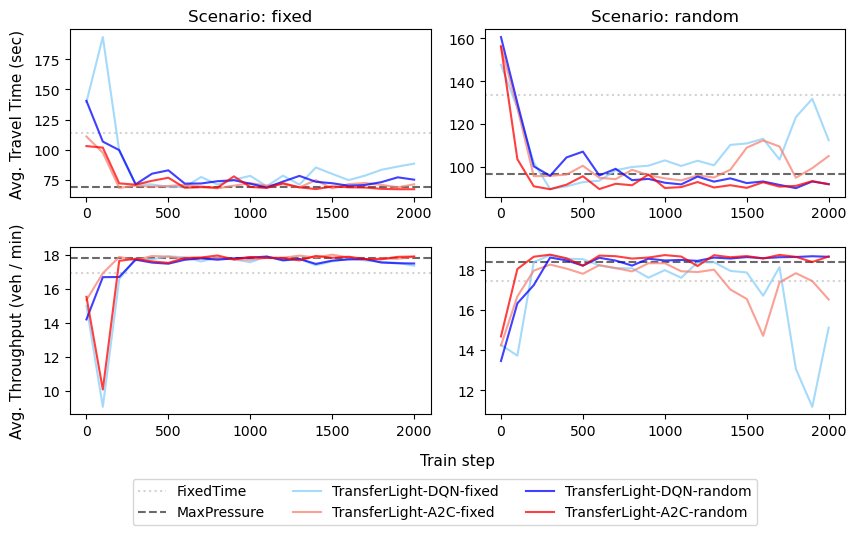

In [68]:
metric_stats = {"Avg. Travel Time (sec)": agg_travel_time_df, "Avg. Throughput (veh / min)": agg_throughput_df}
plt = plot_training_curve(metric_stats, ["fixed", "random"], ["TransferLight-DQN-fixed", "TransferLight-A2C-fixed", "TransferLight-DQN-random", "TransferLight-A2C-random"])
plt.savefig("learning-curves.pdf", bbox_inches="tight")
plt.show()

## Zero-Shot Transferability

In [114]:
def plot_comparison_bar_chart(metric: str, stats: pd.DataFrame, scenarios: List[str], agents: List[str], agent_colors: Dict[str, str] = agent_colors, ascending: bool = True):
    n_cols = 2
    n_rows = int(np.ceil(len(scenarios) / n_cols))
    ax_scenario_stats, ax_scenario = {}, {}
    for i, scenario in enumerate(scenarios):
        row = i // n_cols
        col = i % n_cols
        ax_scenario[row, col] = scenario
        ax_scenario_stats[row, col] = (
            stats
            .query('checkpoint == "best"')
            .query(f'scenario == "{scenario}"')
            .query('agent in @agents')
            .sort_values('mean', ascending=ascending)
        )
        
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 17.5))
    for (row, col) in [(row, col) for row in range(n_rows) for col in range(n_cols)]:
        ax = axs[row, col] if n_rows > 1 else axs[col]
        scenario = ax_scenario[(row, col)]
        scenario_stats = ax_scenario_stats[(row, col)]
        agent_names = scenario_stats["agent"].tolist()
        means = scenario_stats["mean"]
        stds = scenario_stats["std"]
        counts = scenario_stats["count"]
        colors = [agent_colors[agent] for agent in agent_names]
        bars = [i for i in range(len(agent_names))]
        tick_labels = [r"$\bar{x}\approx$" + f"{np.round(mean, 2)}" + "\n" + r"$s\approx$" + f"{np.round(std, 2)}" + "\n" + f"n={int(count)}" for mean, std, count in zip(means, stds, counts)]
        ax.bar(bars, means, color=colors, alpha=0.9)
        ax.set_ylim(bottom=0, top=max(means + stds) + 10)
        ax.errorbar(bars, means, yerr=stds, fmt="o", color="black")
        ax.set_title(f"Scenario: {scenario}", fontsize=20)
        ax.set_xticks(bars)
        ax.set_xticklabels(tick_labels, fontsize=10)
        ax.yaxis.grid(color="gray", linestyle="dashed")
        ax.set_axisbelow(True)
    
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in agent_colors.items()]
    
    plt.subplots_adjust(wspace=0.1, hspace=0.35)
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    ax.set_ylabel(metric, fontsize=20)
    ax.yaxis.set_label_coords(-0.05, 0.5)
    fig.legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.0005), fancybox=True, ncol=4, fontsize=13)

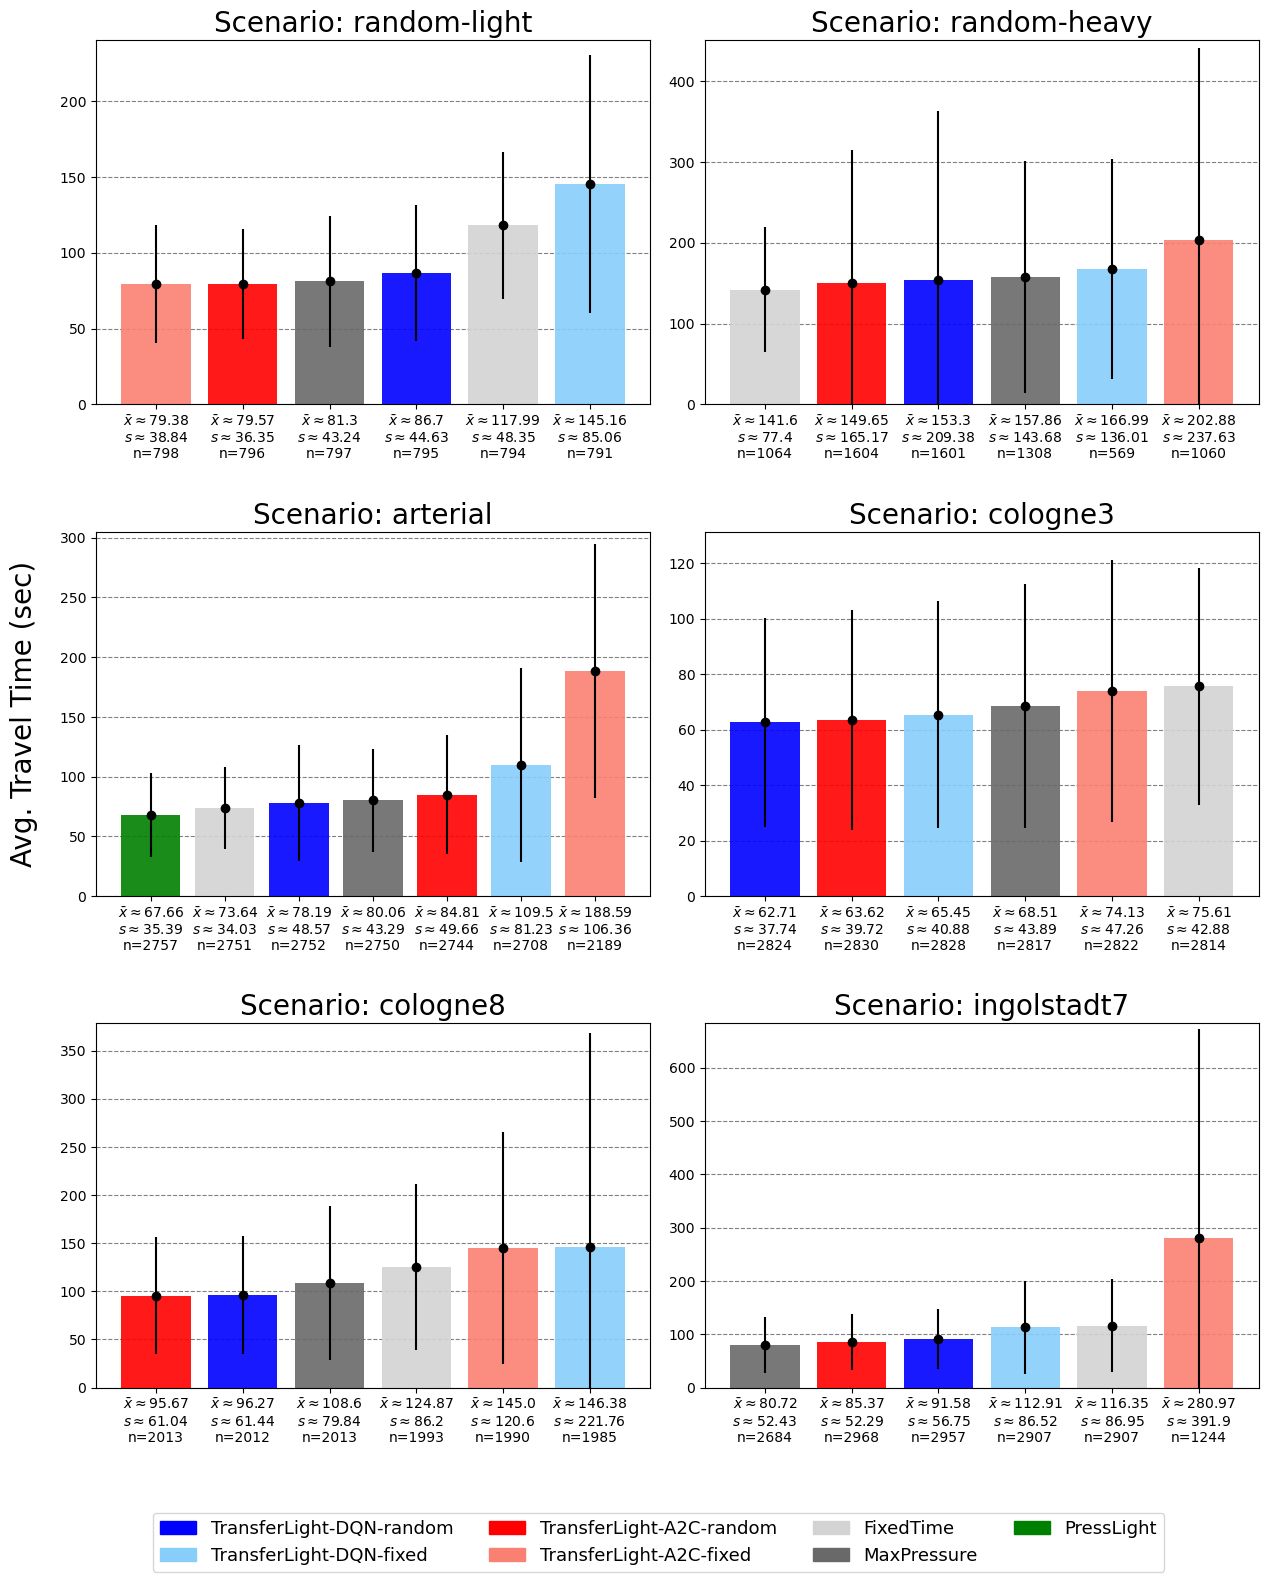

In [115]:
plot_comparison_bar_chart("Avg. Travel Time (sec)", agg_travel_time_df, ["random-light", "random-heavy", "arterial", "cologne3", "cologne8", "ingolstadt7"], ["FixedTime", "MaxPressure", "PressLight", "TransferLight-DQN-fixed", "TransferLight-A2C-fixed", "TransferLight-DQN-random", "TransferLight-A2C-random"])

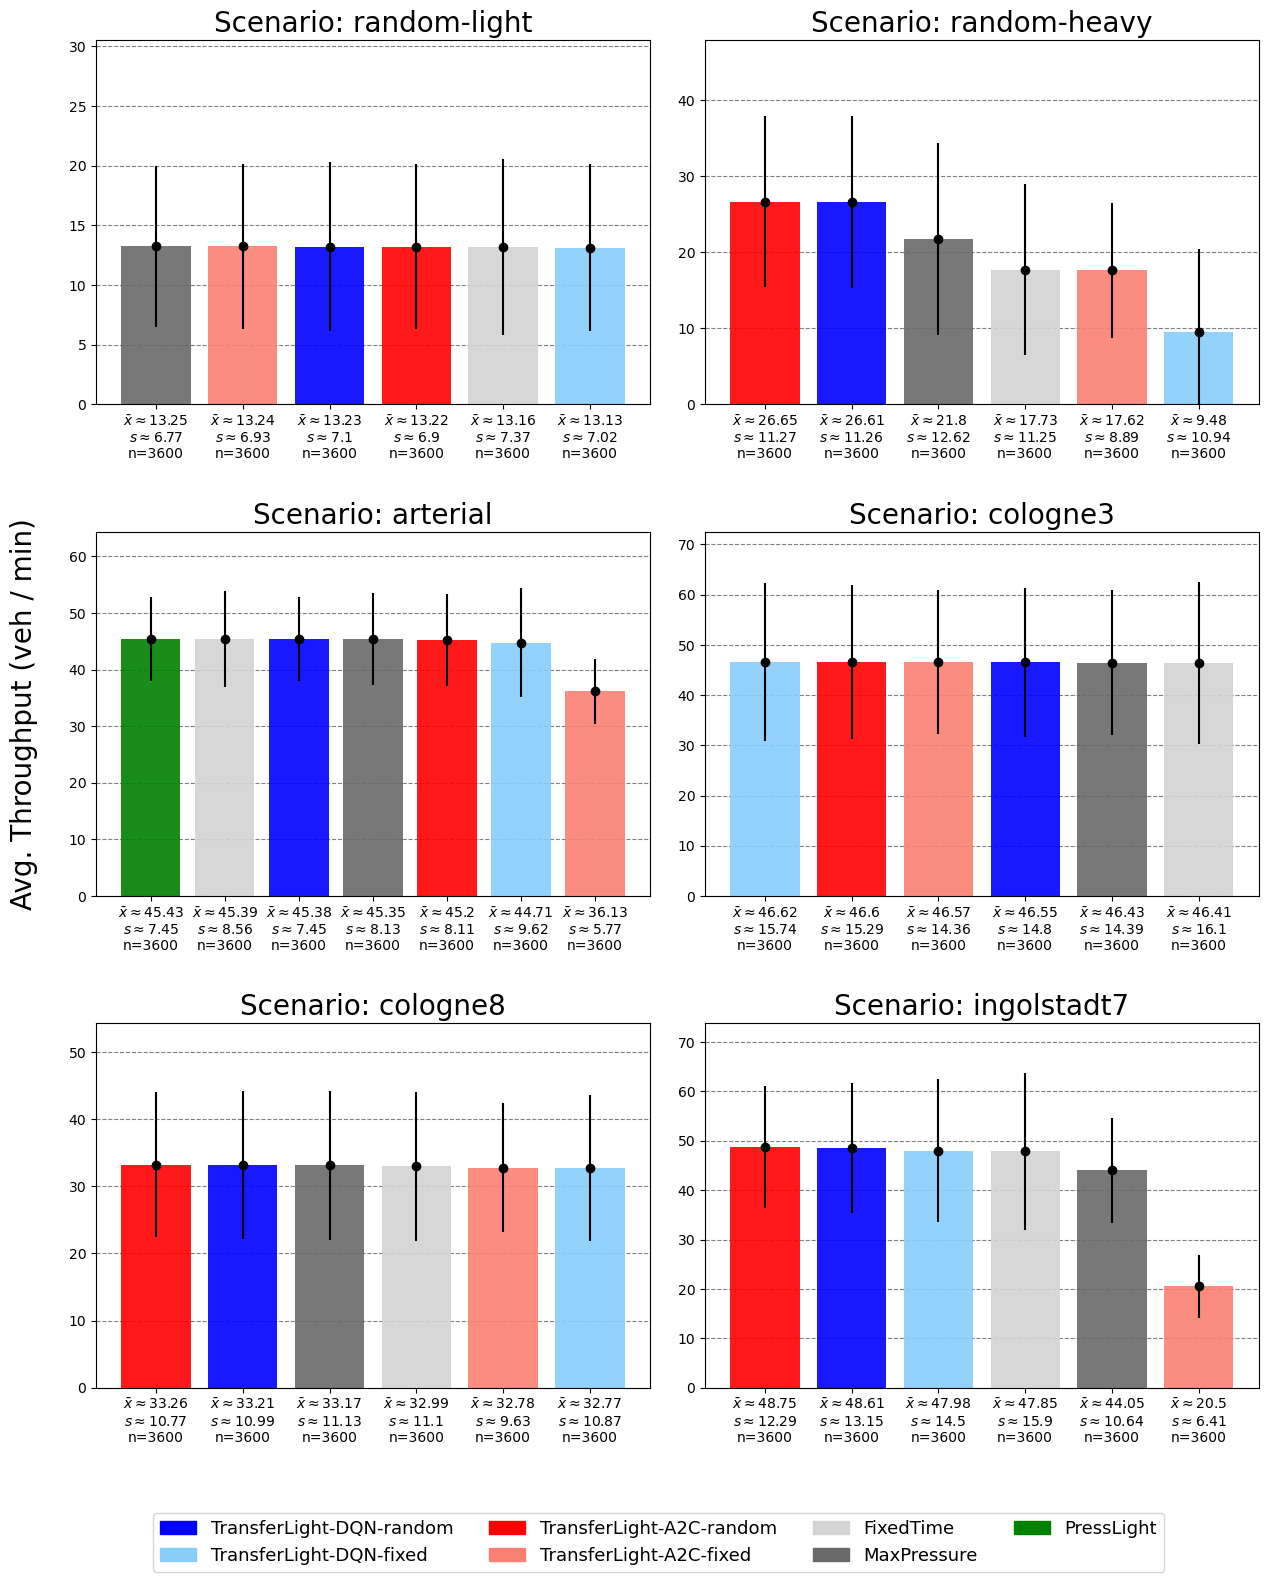

In [116]:
plot_comparison_bar_chart("Avg. Throughput (veh / min)", agg_throughput_df, ["random-light", "random-heavy", "arterial", "cologne3", "cologne8", "ingolstadt7"], ["FixedTime", "MaxPressure", "PressLight", "TransferLight-DQN-fixed", "TransferLight-A2C-fixed", "TransferLight-DQN-random", "TransferLight-A2C-random"], ascending=False)

In [70]:
from scipy.interpolate import make_smoothing_spline


def plot_temporal_change(metric: str, stats: pd.DataFrame, scenarios: List[str], agents: List[str], agent_colors: Dict[str, str] = agent_colors):
    n_cols = 1
    n_rows = int(np.ceil(len(scenarios) / n_cols))
    ax_scenario_stats, ax_scenario = {}, {}
    for i, scenario in enumerate(scenarios):
        row = i // n_cols
        col = i % n_cols
        ax_scenario[row, col] = scenario
        ax_scenario_stats[row, col] = (
            stats
            .query('checkpoint == "best"')
            .query(f'scenario == "{scenario}"')
            .query('agent in @agents')
        )
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5))
    for (row, col) in [(row, col) for row in range(n_rows) for col in range(n_cols)]:
        ax = axs[row, col] if n_rows > 1 else axs[col] if n_cols > 1 else axs
        scenario = ax_scenario[(row, col)]
        scenario_stats = ax_scenario_stats[(row, col)]
        scenario_agents = scenario_stats["agent"].unique()
        for agent in agents:
            if agent not in scenario_agents:
                continue
            agent_scenario_stats = scenario_stats.query(f'agent == "{agent}"').sort_values("time")
            x = agent_scenario_stats["time"]
            y = agent_scenario_stats["value"]
            spline = make_smoothing_spline(x, y)
            x = np.linspace(x.min(), x.max(), 100)
            y = spline(x)
            
            ax.plot(x, y, color=agent_colors[agent])

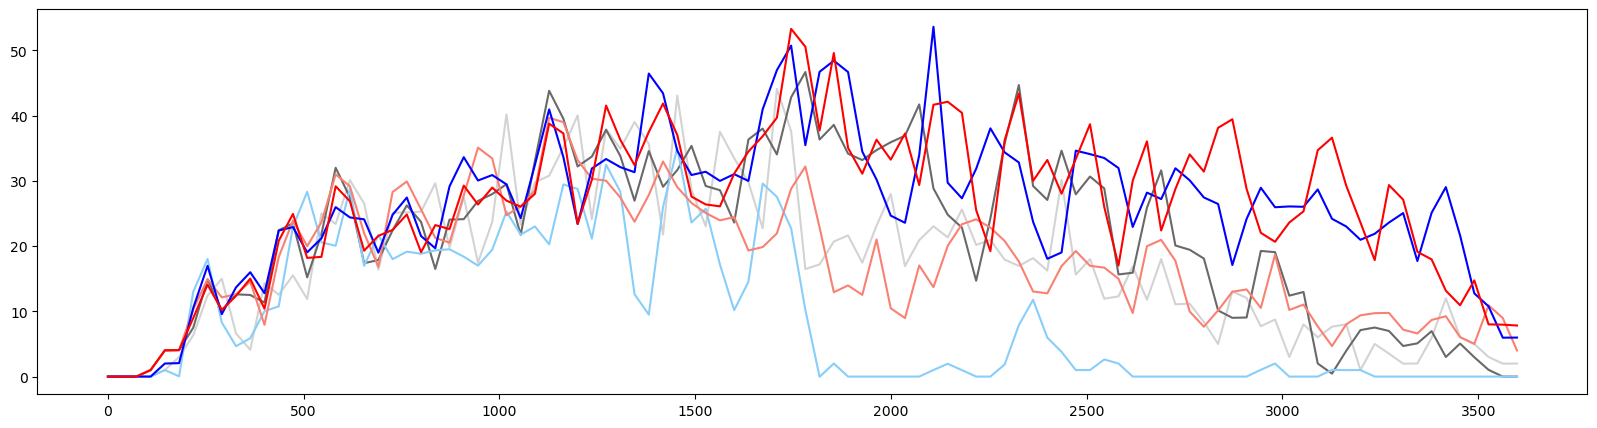

In [71]:
plot_temporal_change("Throughput (veh / min)", throughput_df, ["random-heavy"], ["FixedTime", "MaxPressure", "PressLight", "TransferLight-DQN-fixed", "TransferLight-A2C-fixed", "TransferLight-DQN-random", "TransferLight-A2C-random"])

In [12]:
throughput_df

,agent,checkpoint,specific_scenario,scenario,time,throughput
0,FixedTime,best,arterial/1,arterial,0,0.0
1,FixedTime,best,arterial/1,arterial,1,0.0
2,FixedTime,best,arterial/1,arterial,2,0.0
3,FixedTime,best,arterial/1,arterial,3,0.0
4,FixedTime,best,arterial/1,arterial,4,0.0
...,...,...,...,...,...,...
1061995,TransferLight-DQN-random,best,random-light/1,random-light,3595,4.0
1061996,TransferLight-DQN-random,best,random-light/1,random-light,3596,3.0
1061997,TransferLight-DQN-random,best,random-light/1,random-light,3597,3.0
1061998,TransferLight-DQN-random,best,random-light/1,random-light,3598,3.0


In [55]:
throughput_df.query('agent == "PressLight"')

,agent,checkpoint,specific_scenario,scenario,time,value
64800,PressLight,best,arterial/1,arterial,0,0.0
64801,PressLight,best,arterial/1,arterial,1,0.0
64802,PressLight,best,arterial/1,arterial,2,0.0
64803,PressLight,best,arterial/1,arterial,3,0.0
64804,PressLight,best,arterial/1,arterial,4,0.0
...,...,...,...,...,...,...
68395,PressLight,best,arterial/1,arterial,3595,46.0
68396,PressLight,best,arterial/1,arterial,3596,46.0
68397,PressLight,best,arterial/1,arterial,3597,45.0
68398,PressLight,best,arterial/1,arterial,3598,46.0
